# Set Up The Environment

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, brier_score_loss
import json
import os
import warnings
import requests
from statsbombpy import sb
from tqdm import tqdm


In [2]:
pd.set_option("display.max_columns", None)
data_dir = f"{os.path.abspath(os.path.join(os.getcwd(), '..'))}/data/"

# Suppress the NoAuthWarning from statsbombpy
warnings.filterwarnings("ignore", category=UserWarning, module="statsbombpy")

# Get Statsbomb Data

In [6]:
comps = sb.competitions()
comps = comps[comps["competition_gender"] == "male"]
comps[["competition_name", "competition_id", "season_id", "season_name"]]
comps_list_of_tuples = list(
    comps[["competition_id", "competition_name", "season_id", "season_name"]].itertuples(index=False, name=None)
)

In [8]:
# URL template for lineups
lineups_url_template = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/lineups/{match_id}.json"


# Example function to get match_ids
def get_match_ids(competition_id, season_id):
    # URL for matches in a specific competition and season
    matches_url = (
        f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json"
    )

    # Fetch the matches data
    response = requests.get(matches_url)
    matches_data = response.json()

    # Extract match_ids
    match_ids = [match["match_id"] for match in matches_data]
    return match_ids

In [14]:
for comp in tqdm(comps_list_of_tuples[2:], desc="Processing Competitions"):
    competition_id = comp[0]
    competition_name = comp[1]
    season_id = comp[2]
    season_name = comp[3]

    match_ids = get_match_ids(competition_id, season_id)

    required_columns = [
        "location",
        "minute",
        "play_pattern",
        "player",
        "player_id",
        "position",
        "possession",
        "possession_team",
        "possession_team_id",
        "second",
        "shot_aerial_won",
        "shot_body_part",
        "shot_first_time",
        "shot_freeze_frame",
        "shot_one_on_one",
        "shot_outcome",
        "shot_statsbomb_xg",
        "shot_technique",
        "shot_type",
        "team",
        "team_id",
        "timestamp",
        "type",
        "under_pressure",
    ]

    # Initialize a list to store all events data
    all_events_data = []

    for match_id in match_ids:
        events = sb.events(match_id=match_id)
        for col in required_columns:
            if col not in events.columns:
                events[col] = np.nan

        shot_events = events[events["type"] == "Shot"][required_columns]

        # Add match_id to each event
        shot_events["match_id"] = match_id

        # Append to the list
        all_events_data.append(shot_events)

    # Concatenate all events data into a single DataFrame
    all_events_df = pd.concat(all_events_data, ignore_index=True)
    # Add competition and season information
    all_events_df["competition_id"] = competition_id
    all_events_df["competition_name"] = competition_name
    all_events_df["season_id"] = season_id
    all_events_df["season_name"] = season_name

    all_events_df.to_parquet(f"{data_dir}/{competition_id}_{season_id}.parquet", index=False)

Processing Competitions: 100%|██████████| 65/65 [39:36<00:00, 36.55s/it] 


# Load Data

In [3]:
files = os.listdir(data_dir)
parquet_files = [f for f in files if f.endswith('.parquet')]

# Read and concatenate all parquet files
df_list = [pd.read_parquet(os.path.join(data_dir, f)) for f in parquet_files]
df = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(df)} rows of data")

Loaded 65127 rows of data


# Prepare Features

In [44]:
# We need to extract relevant features from the shot data
def extract_shot_features(shots_df):
    features = []

    for _, shot in shots_df.iterrows():
        # Basic location info
        x = shot['location'][0]
        y = shot['location'][1]

        # Calculate distance and angle to goal
        # Pitch dimensions: 120 x 80 in StatsBomb coordinates
        distance = np.sqrt((x - 120)**2 + (y - 40)**2)
        angle = np.abs(np.arctan2(y - 40, 120 - x))

        # Shot outcome (our target variable)
        outcome = 1 if shot['shot_outcome'] == 'Goal' else 0

        # Other features
        body_part = shot['shot_body_part'] if 'shot_body_part' in shot else 'Unknown'
        shot_type = shot['shot_type'] if 'shot_type' in shot else 'Unknown'
        technique = shot['shot_technique'] if 'shot_technique' in shot else 'Unknown'

        # More advanced features (if available)
        under_pressure = 1 if 'under_pressure' in shot and shot['under_pressure'] else 0
        first_time = 1 if 'shot_first_time' in shot and shot['shot_first_time'] else 0

        # Game period categories
        minute = shot.get('minute', 0)
        if minute < 15:
            game_period = 'Opening'
        elif minute < 40:
            game_period = 'First Half'
        elif minute < 45:
            game_period = 'First Half Ending'
        elif minute < 60:
            game_period = 'Second Half Beginning'
        elif minute < 80:
            game_period = 'Second Half'
        else:
            game_period = 'Closing Minutes'

        # FEATURE: Defender positions
        # Count defenders between shot and goal, and find closest defender
        defenders_in_path = 0
        min_defender_distance = 100  # Initialize with large value

        # Get freeze frame if available
        if 'shot_freeze_frame' in shot and shot['shot_freeze_frame'] is not None:
            freeze_frame = shot['shot_freeze_frame']

            # Goal coordinates
            goal_x = 120
            goal_y = 40

            for player in freeze_frame:
                if player['teammate'] == False and player['position'] != 'Goalkeeper':
                    # Check if defender is between shot and goal
                    player_x = player['location'][0]
                    player_y = player['location'][1]

                    # Simple check - if defender is in the "cone" from shot to goal
                    if player_x > x:  # Defender is closer to goal than shooter
                        # Calculate if defender is in path (simplified approach)
                        shot_to_goal_angle = np.arctan2(goal_y - y, goal_x - x)
                        shot_to_defender_angle = np.arctan2(player_y - y, player_x - x)

                        # If angles are close, defender is in path
                        if abs(shot_to_goal_angle - shot_to_defender_angle) < 0.3:  # ~17 degrees
                            defenders_in_path += 1

                    # Calculate distance to nearest defender
                    defender_distance = np.sqrt((player_x - x)**2 + (player_y - y)**2)
                    min_defender_distance = min(min_defender_distance, defender_distance)
        # IF we don't have a freeze frame, we will impute the values later
        else:
            defenders_in_path = None
            min_defender_distance = None

        if min_defender_distance == 100:  # No defenders found
            min_defender_distance = 20

        # NEW FEATURE 4: Goalkeeper position
        gk_distance = 15  # Default value
        gk_angle = 0  # Default value

        if 'shot_freeze_frame' in shot and shot['shot_freeze_frame'] is not None:
            for player in shot['shot_freeze_frame']:
                if player['teammate'] == False and player['position']['name'] == 'Goalkeeper':
                    gk_x = player['location'][0]
                    gk_y = player['location'][1]

                    # Distance from shooter to goalkeeper
                    gk_distance = np.sqrt((gk_x - x)**2 + (gk_y - y)**2)
                    # Distance from goalkeeper to goal line
                    gk_goal_line_distance = 120 - gk_x

                    # Angle between shot trajectory and goalkeeper
                    shot_to_goal_angle = np.arctan2(40 - y, 120 - x)
                    shot_to_gk_angle = np.arctan2(gk_y - y, gk_x - x)
                    gk_angle = abs(shot_to_goal_angle - shot_to_gk_angle)
        # IF we don't have a freeze frame, we will impute the values later
        else:
            gk_distance = None
            gk_angle = None

        features.append({
            'x': x,
            'y': y,
            'distance': distance,
            'angle': angle,
            'body_part': body_part,
            'shot_type': shot_type,
            'technique': technique,
            'under_pressure': under_pressure,
            'first_time': first_time,
            # New features
            'minute': minute,
            'game_period': game_period,
            'defenders_in_path': defenders_in_path,
            'min_defender_distance': min_defender_distance,
            'gk_distance': gk_distance,
            'gk_angle': gk_angle,
            'gk_goal_line_distance': gk_goal_line_distance,
            # Result
            'goal': outcome
        })


    return pd.DataFrame(features)

In [45]:
shot_features = extract_shot_features(df)

In [49]:
# Calculate mean values for imputation
defenders_in_path_mean = shot_features['defenders_in_path'].median()
min_defender_distance_mean = shot_features['min_defender_distance'].median()
gk_distance_mean = shot_features['gk_distance'].median()
gk_angle_mean = shot_features['gk_angle'].median()
gk_goal_line_distance_mean = shot_features['gk_goal_line_distance'].median()

print(f"Defenders in path: {defenders_in_path_mean}")
print(f"Min defender distance: {min_defender_distance_mean}")
print(f"GK distance: {gk_distance_mean}")
print(f"GK goal line distance: {gk_goal_line_distance_mean}")
print(f"GK angle: {gk_angle_mean}")

# Fill missing values using DataFrame's fillna with a dictionary
shot_features.fillna({
    'defenders_in_path': defenders_in_path_mean,
    'min_defender_distance': min_defender_distance_mean,
    'gk_distance': gk_distance_mean,
    'gk_angle': gk_angle_mean,
    'gk_goal_line_distance': gk_goal_line_distance_mean
}, inplace=True)

Defenders in path: 2.0
Min defender distance: 2.3430749027719995
GK distance: 15.376930773076923
GK goal line distance: 2.0
GK angle: 0.034879005766847326


# Prepare Training Data

In [51]:
# Handle categorical variables
shot_features_processed = pd.get_dummies(shot_features, columns=['body_part', 'shot_type', 'technique', 'game_period'], drop_first=True)

# Split data
X = shot_features_processed.drop('goal', axis=1)
y = shot_features_processed['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
shot_features_processed

,x,y,distance,angle,under_pressure,first_time,minute,defenders_in_path,min_defender_distance,gk_distance,gk_angle,gk_goal_line_distance,goal,body_part_Left Foot,body_part_Other,body_part_Right Foot,shot_type_Free Kick,shot_type_Open Play,shot_type_Penalty,technique_Diving Header,technique_Half Volley,technique_Lob,technique_Normal,technique_Overhead Kick,technique_Volley,game_period_First Half,game_period_First Half Ending,game_period_Opening,game_period_Second Half,game_period_Second Half Beginning
0,92.6,48.8,28.778464,0.310762,0,1,1,4.0,6.612866,28.122055,0.014877,0.5,0,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
1,97.6,32.4,23.654175,0.327098,0,0,4,3.0,4.100000,21.345960,0.002060,2.2,0,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
2,110.7,32.5,11.947385,0.678662,1,0,8,1.0,0.824621,9.985990,0.107325,0.9,0,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
3,99.2,40.0,20.800000,0.000000,1,0,12,3.0,1.204159,19.602296,0.015305,1.2,0,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False
4,112.4,37.3,8.065358,0.341356,1,1,14,0.0,1.303840,6.700000,0.341356,0.9,0,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65122,93.6,47.4,27.417513,0.273290,0,0,82,6.0,7.249828,26.400758,0.002929,1.0,0,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False
65123,93.5,52.2,29.173447,0.431450,0,0,83,4.0,2.657066,27.642178,0.049995,2.0,0,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
65124,102.8,28.0,20.972363,0.609163,0,0,85,4.0,1.676305,17.861971,0.100434,1.6,0,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False
65125,93.8,42.2,26.292204,0.083773,0,0,88,5.0,8.338465,24.040799,0.025506,2.2,0,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False


## Analysis of features

In [53]:
X_train.describe()

,x,y,distance,angle,under_pressure,first_time,minute,defenders_in_path,min_defender_distance,gk_distance,gk_angle,gk_goal_line_distance
count,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000,52101.000000
mean,103.374843,39.656091,19.425433,0.483732,0.231186,0.306923,49.065910,2.300321,3.071271,16.413808,0.079925,2.521681
std,8.851774,9.968844,8.769064,0.328070,0.421595,0.461222,27.198687,1.604695,2.397966,8.900594,0.196562,2.147778
min,30.200000,0.300000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.360555,0.000000,0.000000
25%,97.000000,32.200000,12.184006,0.210364,0.000000,0.000000,26.000000,1.000000,1.431782,9.121403,0.014910,1.300000
50%,104.700000,39.800000,18.787762,0.448440,0.000000,0.000000,49.000000,2.000000,2.343075,15.376931,0.034879,2.000000
75%,110.400000,47.000000,25.742183,0.713698,0.000000,1.000000,72.000000,3.000000,3.820995,23.082461,0.073073,3.100000
max,120.200000,79.600000,89.829450,1.575924,1.000000,1.000000,134.000000,11.000000,35.120507,72.672003,4.601473,69.800000


# Build the Logistic Regression xG Model

ROC AUC: 0.818
Brier score: 0.079


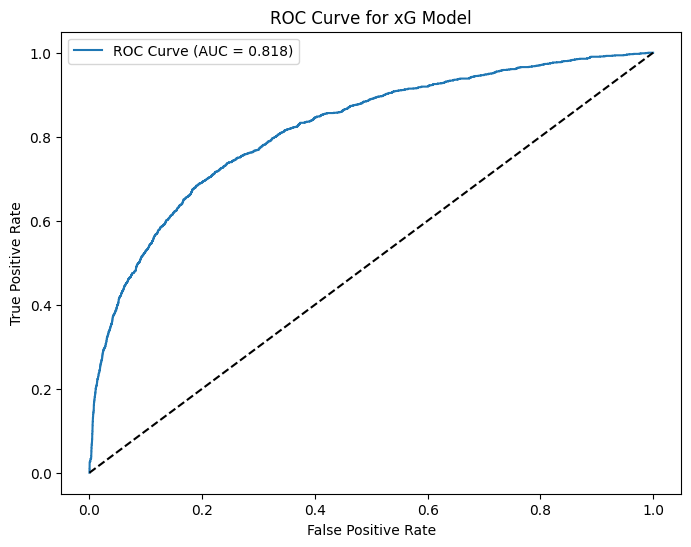

In [54]:
# Logistic Regression is commonly used for xG models
xg_model = LogisticRegression(penalty='l2', solver='liblinear')
xg_model.fit(X_train, y_train)

# Make predictions
y_pred_proba = xg_model.predict_proba(X_test)[:, 1]  # Probability of goal

# Evaluate model
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print(f"Brier score: {brier_score_loss(y_test, y_pred_proba):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for xG Model')
plt.legend()
plt.show()

# Visualize xG on a Football Pitch

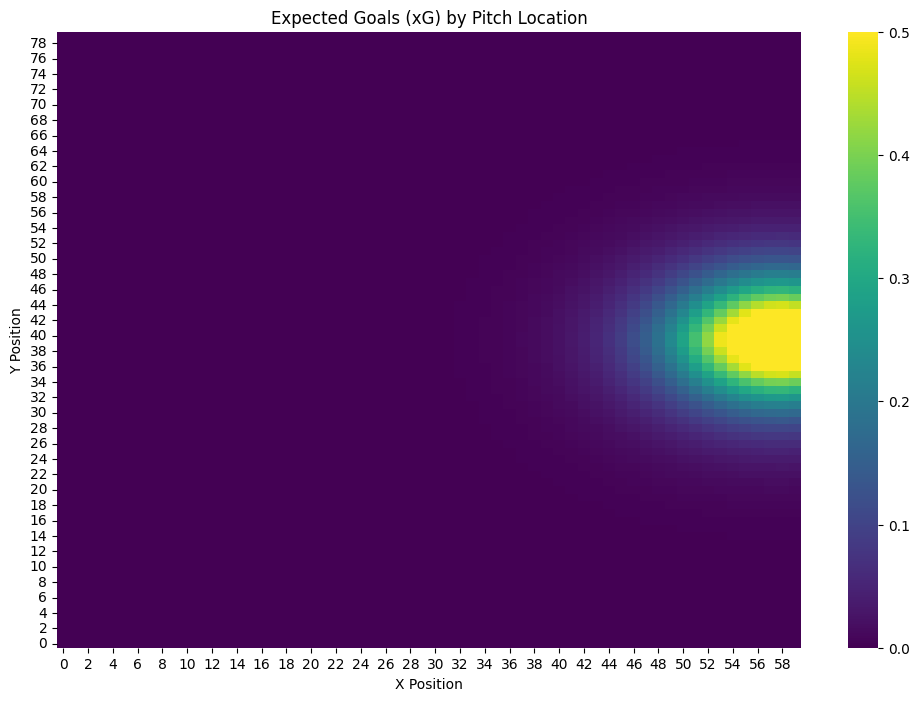

In [58]:
# Create a heatmap of xG values on a soccer pitch
def plot_xg_heatmap(model):
    # Create a grid of pitch locations
    x_grid = np.linspace(60, 120, 60)  # Only attacking half
    y_grid = np.linspace(0, 80, 80)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Calculate features for each point
    grid_points = []
    for x, y in zip(xx.flatten(), yy.flatten()):
        distance = np.sqrt((x - 120)**2 + (y - 40)**2)
        angle = np.abs(np.arctan2(y - 40, 120 - x))

        grid_points.append({
            'x': x,
            'y': y,
            'distance': distance,
            'angle': angle,
            'under_pressure': 0,  # Assumptions for visualization
            'first_time': 0,
            'body_part_Foot': 1,  # Assuming right foot shot
            'body_part_Head': 0,
            'shot_type_Open Play': 1,
            'technique_Normal': 1,
            'game_period_First Half': 1,
            'defenders_in_path': 2.0,
            'min_defender_distance': 2.3430749027719995,
            'gk_distance': 15.376930773076923,
            'gk_angle': 0.034879005766847326,
            'gk_goal_line_distance': 2.0
        })

    grid_df = pd.DataFrame(grid_points)

    # Match columns with training data
    missing_cols = set(X.columns) - set(grid_df.columns)
    for col in missing_cols:
        grid_df[col] = 0

    grid_df = grid_df[X.columns]

    # Predict xG
    xg_values = model.predict_proba(grid_df)[:, 1]

    # Reshape for heatmap
    xg_grid = xg_values.reshape(len(y_grid), len(x_grid))

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(xg_grid, cmap='viridis', vmin=0, vmax=0.5)
    plt.title('Expected Goals (xG) by Pitch Location')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.gca().invert_yaxis()
    plt.show()

plot_xg_heatmap(xg_model)

# XGBoost Model

## Setup XGBoost

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, log_loss

## Train both models using grid search

In [65]:
# Prepare the data (assuming you've already created X_train, X_test, y_train, y_test)

# 1. Logistic Regression with hyperparameter tuning
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [2000],
    'class_weight': [None, 'balanced']
}

log_grid_search = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid=log_param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

log_grid_search.fit(X_train, y_train)
log_model = log_grid_search.best_estimator_

print(f"Best Logistic Regression parameters: {log_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {log_grid_search.best_score_:.4f}")

# 2. XGBoost with hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# For a quicker initial run, you can use a smaller grid:
# xgb_param_grid_small = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.8],
# }

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)

xgb_grid_search = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,  # Use the smaller grid for initial testing
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)
xgb_best = xgb_grid_search.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {xgb_grid_search.best_score_:.4f}")

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Logistic Regression parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV ROC-AUC: 0.8238
Fitting 4 folds for each of 729 candidates, totalling 2916 fits
Best XGBoost parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Best CV ROC-AUC: 0.8275


## Evaluate the models

                 Model   ROC AUC  Brier Score  Log Loss
0  Logistic Regression  0.819005     0.168831  0.514829
1              XGBoost  0.821664     0.076948  0.268466
2            StatsBomb  0.819741     0.077235  0.270195


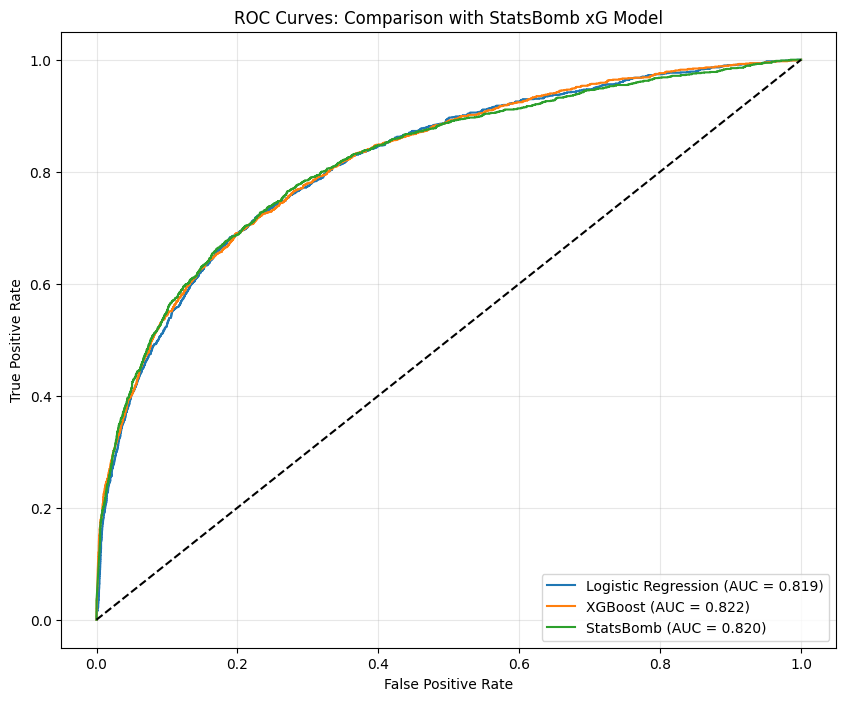

In [67]:
# Make predictions with both models
log_pred_proba = log_model.predict_proba(X_test)[:, 1]
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Compare with StatsBomb's xG model
# First, we need to get the StatsBomb xG values for our test set
# We'll match the test indices back to the original dataframe

# Create mapping from shot features to original data
# Assuming indices in shot_features correspond to df
test_indices = y_test.index
sb_xg_test = df.iloc[test_indices]['shot_statsbomb_xg'].values
sb_xg_test = np.clip(sb_xg_test, 0.001, 0.999)  # Clip to avoid log(0) errors

# Calculate metrics for StatsBomb model
sb_roc_auc = roc_auc_score(y_test, sb_xg_test)
sb_brier = brier_score_loss(y_test, sb_xg_test)
sb_log_loss = log_loss(y_test, sb_xg_test)

# Add StatsBomb metrics to comparison dataframe
metrics_with_sb = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'StatsBomb'],
    'ROC AUC': [roc_auc_score(y_test, log_pred_proba), 
                roc_auc_score(y_test, xgb_pred_proba),
                sb_roc_auc],
    'Brier Score': [brier_score_loss(y_test, log_pred_proba), 
                    brier_score_loss(y_test, xgb_pred_proba),
                    sb_brier],
    'Log Loss': [log_loss(y_test, log_pred_proba), 
                log_loss(y_test, xgb_pred_proba),
                sb_log_loss]
})

print(metrics_with_sb)

# Plot ROC curves with StatsBomb included
plt.figure(figsize=(10, 8))

# ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_proba)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_pred_proba):.3f})')

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')

# ROC for StatsBomb
fpr_sb, tpr_sb, _ = roc_curve(y_test, sb_xg_test)
plt.plot(fpr_sb, tpr_sb, label=f'StatsBomb (AUC = {sb_roc_auc:.3f})')

# Reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Comparison with StatsBomb xG Model')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Compare Calibration Curves

Calibration is especially important for xG models since we want the predicted probabilities to accurately reflect actual goal frequencies:

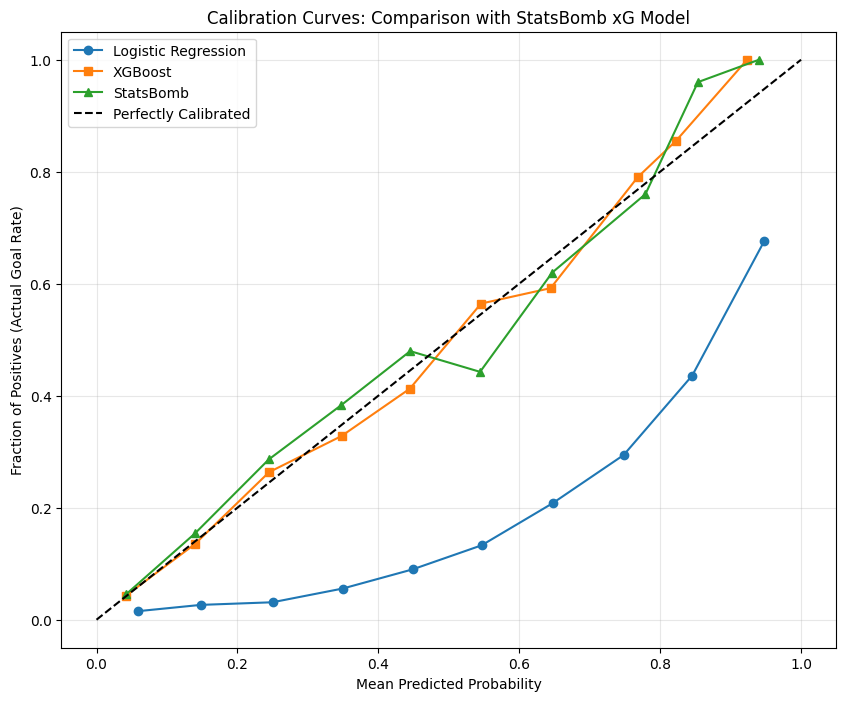

In [68]:
# Calibration curve comparison
plt.figure(figsize=(10, 8))

# Calibration curve for Logistic Regression
prob_true_log, prob_pred_log = calibration_curve(y_test, log_pred_proba, n_bins=10)
plt.plot(prob_pred_log, prob_true_log, marker='o', label=f'Logistic Regression')

# Calibration curve for XGBoost
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, xgb_pred_proba, n_bins=10)
plt.plot(prob_pred_xgb, prob_true_xgb, marker='s', label=f'XGBoost')

# Calibration curve for StatsBomb
prob_true_sb, prob_pred_sb = calibration_curve(y_test, sb_xg_test, n_bins=10)
plt.plot(prob_pred_sb, prob_true_sb, marker='^', label=f'StatsBomb')

# Perfect calibration
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Goal Rate)')
plt.title('Calibration Curves: Comparison with StatsBomb xG Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Analyze Feature Importance

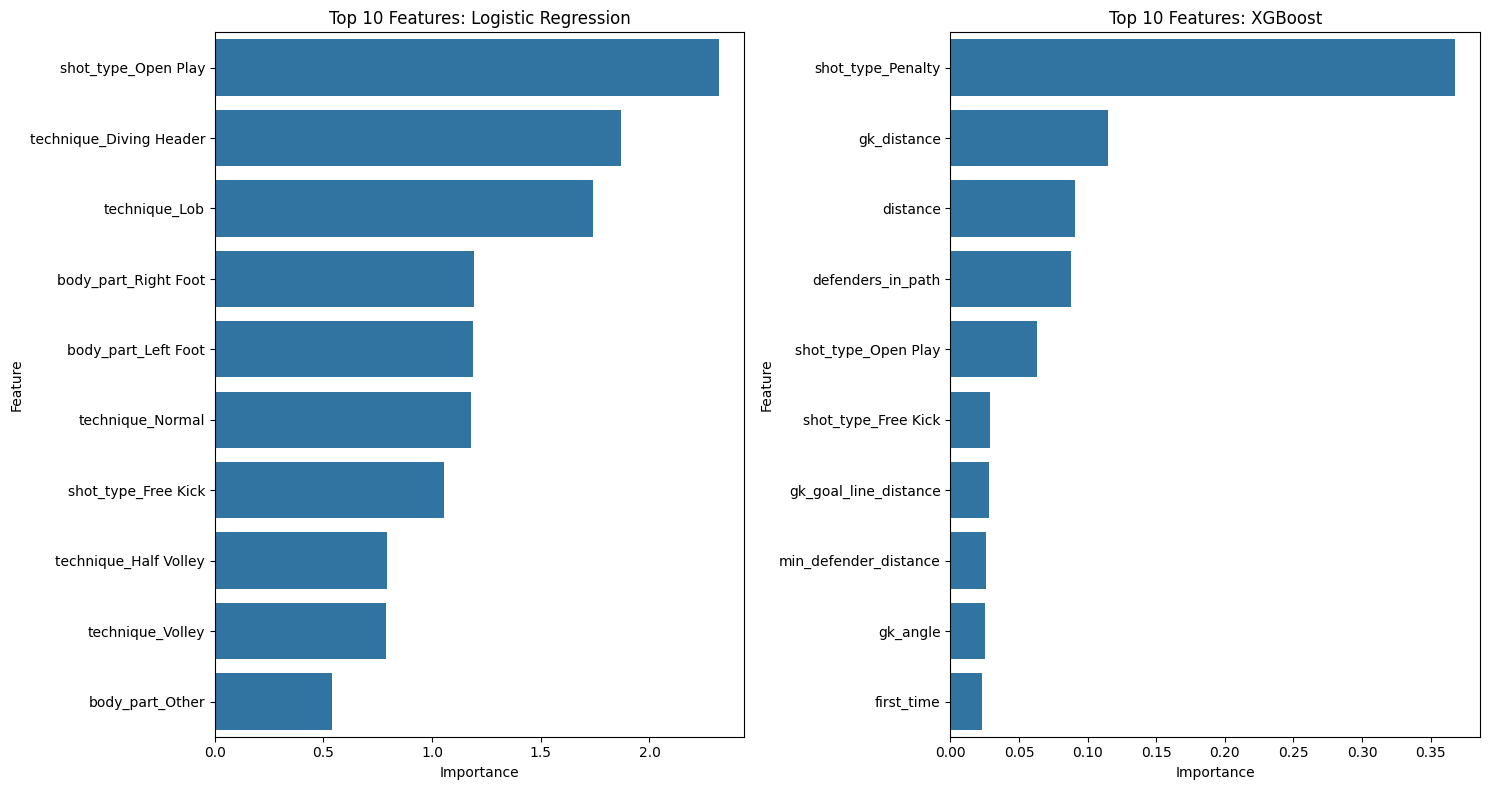

In [69]:
# Feature importance for Logistic Regression
log_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(log_model.coef_[0])
})
log_importance = log_importance.sort_values('Importance', ascending=False)

# Feature importance for XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_best.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)

# Plot feature importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Logistic Regression
top_features_log = log_importance.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features_log, ax=ax1)
ax1.set_title('Top 10 Features: Logistic Regression')

# XGBoost
top_features_xgb = xgb_importance.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features_xgb, ax=ax2)
ax2.set_title('Top 10 Features: XGBoost')

plt.tight_layout()
plt.show()

### Analsis with SHAP

SHAP (SHapley Additive exPlanations) values are used to get a deeper understanding of your xG model's feature importance. SHAP provides more nuanced insights into how each feature contributes to predictions than traditional feature importance methods.

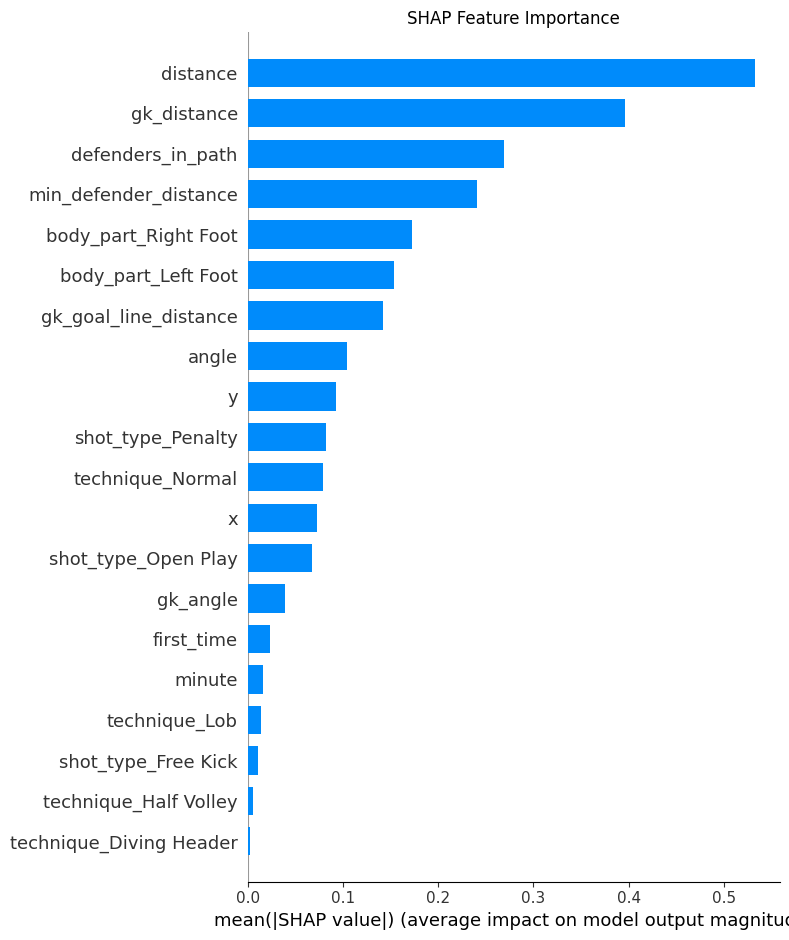

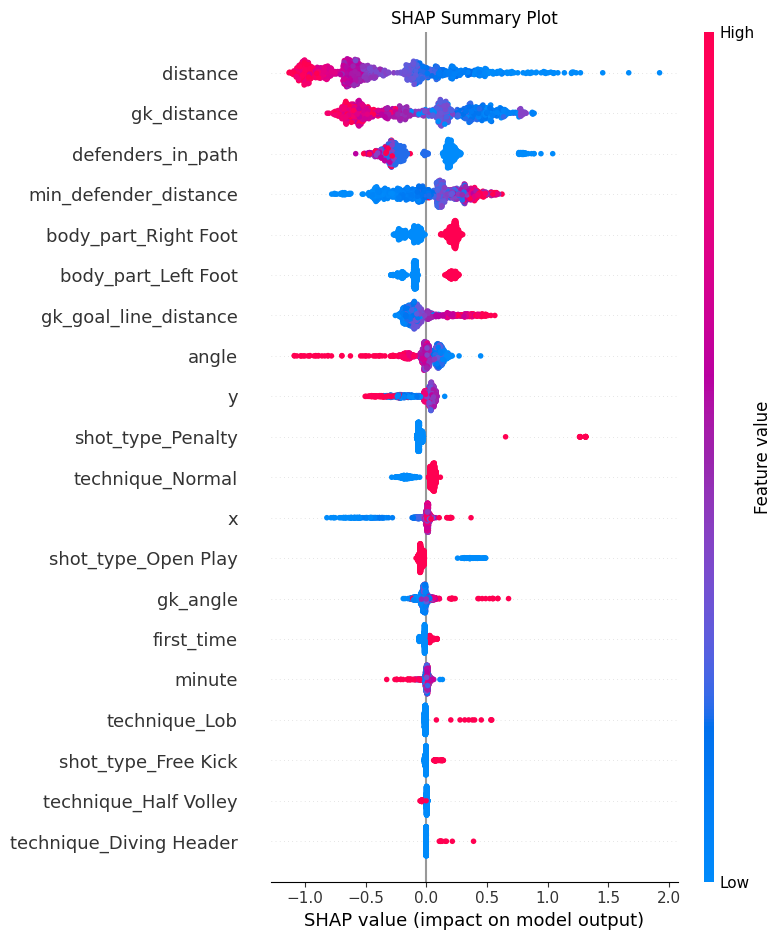

<Figure size 1000x700 with 0 Axes>

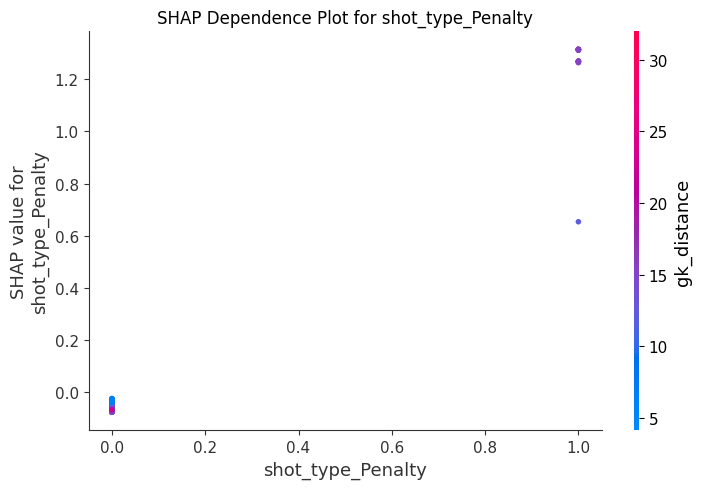

<Figure size 1000x700 with 0 Axes>

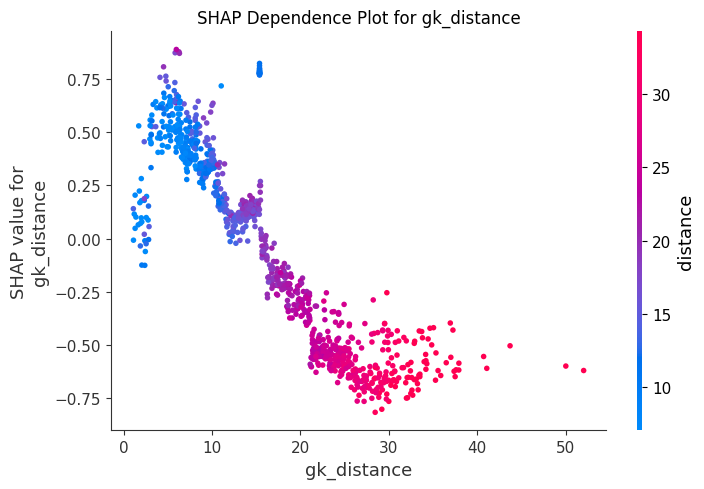

<Figure size 1000x700 with 0 Axes>

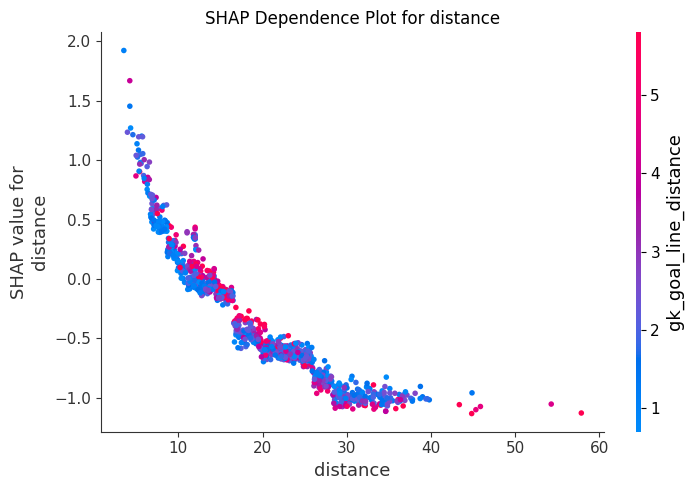

<Figure size 2000x300 with 0 Axes>

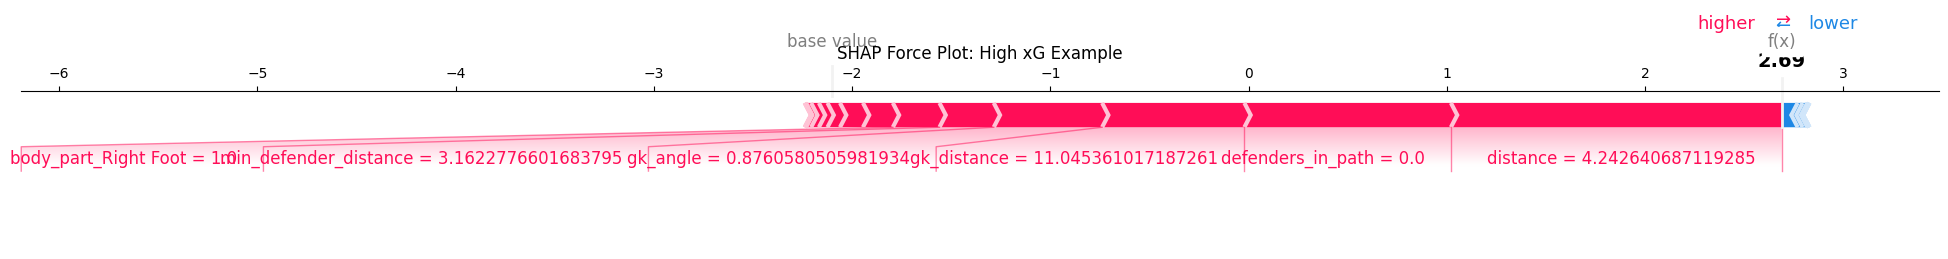

<Figure size 2000x300 with 0 Axes>

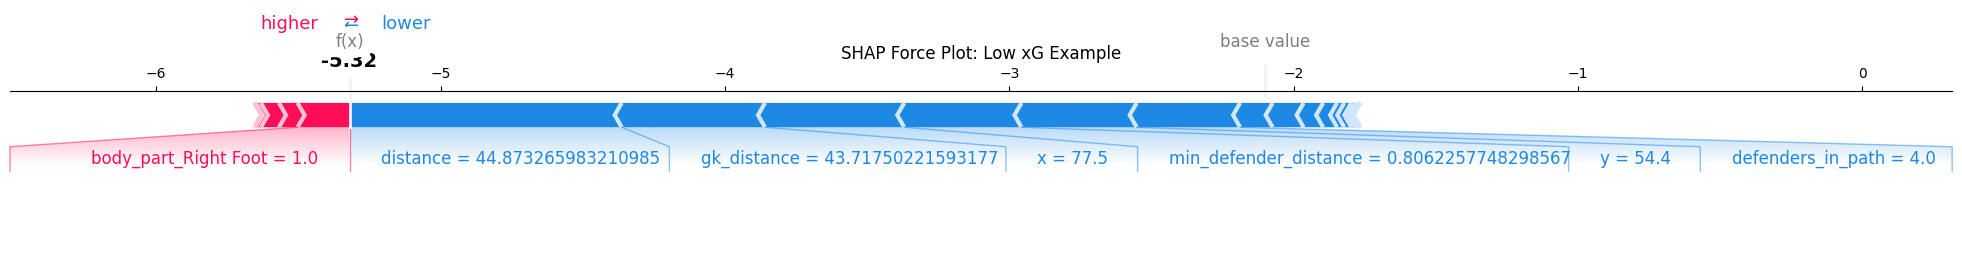

<Figure size 2000x300 with 0 Axes>

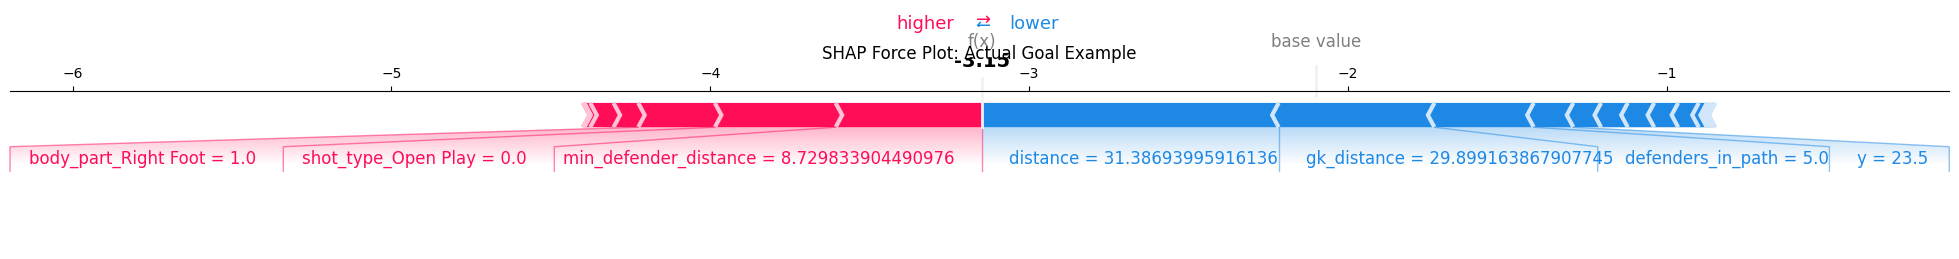

In [72]:
# Import SHAP
import shap

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_best)

# Calculate SHAP values on a sample of the test set (for speed)
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]
shap_values = explainer(X_test_sample)

# Create a summary plot showing the impact of each feature
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Create a summary plot showing both feature importance and effect direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# Detailed dependence plots for top 3 features
# Find the indices of the top 3 features from the XGBoost importance
top_feature_indices = xgb_importance.head(3)['Feature'].values
for feature in top_feature_indices:
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(feature, shap_values.values, X_test_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

# Force plot for a few example predictions
# High xG example
high_xg_idx = np.argmax(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[high_xg_idx].values, 
                X_test_sample.iloc[high_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: High xG Example")
plt.tight_layout()
plt.show()

# Low xG example
low_xg_idx = np.argmin(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[low_xg_idx].values, 
                X_test_sample.iloc[low_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: Low xG Example")
plt.tight_layout()
plt.show()

# Compare with a goal that was actually scored
goal_indices = np.where(y_test.iloc[sample_indices] == 1)[0]
if len(goal_indices) > 0:
    scored_goal_idx = goal_indices[0]
    plt.figure(figsize=(20, 3))
    shap.force_plot(explainer.expected_value, 
                    shap_values[scored_goal_idx].values, 
                    X_test_sample.iloc[scored_goal_idx],
                    matplotlib=True, show=False)
    plt.title("SHAP Force Plot: Actual Goal Example")
    plt.tight_layout()
    plt.show()

## Compare xG Heatmaps

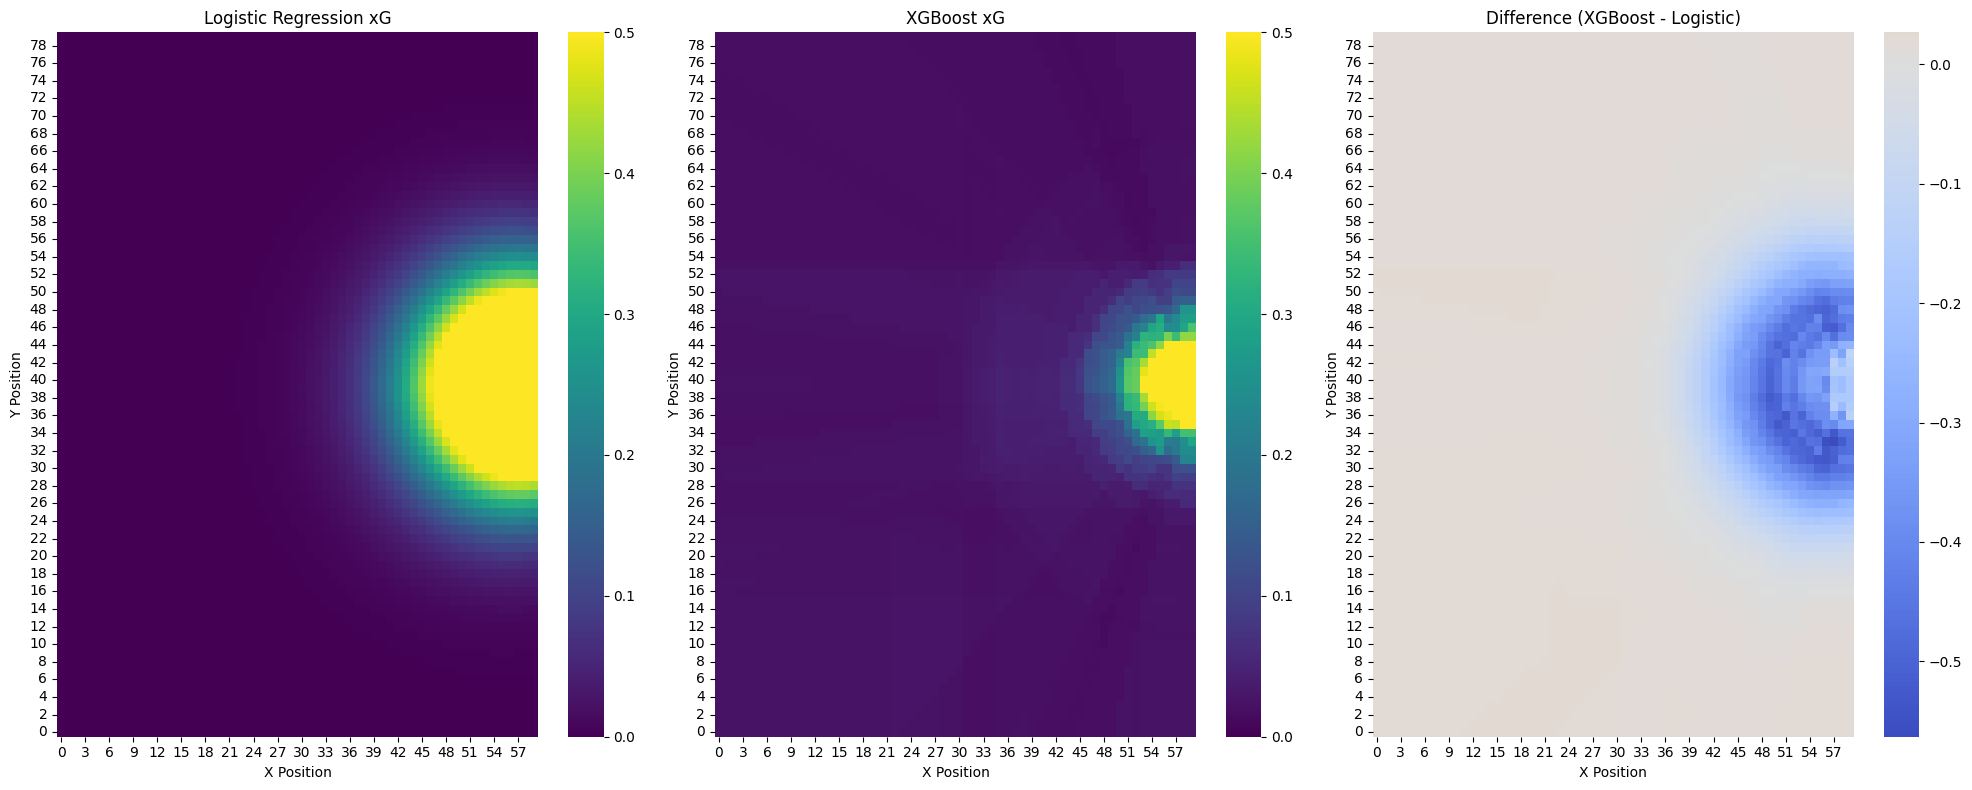

In [71]:
def plot_xg_model_comparison(log_model, xgb_model):
    # Create a grid of pitch locations
    x_grid = np.linspace(60, 120, 60)  # Only attacking half
    y_grid = np.linspace(0, 80, 80)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Calculate features for each point
    grid_points = []
    for x, y in zip(xx.flatten(), yy.flatten()):
        distance = np.sqrt((x - 120)**2 + (y - 40)**2)
        angle = np.abs(np.arctan2(y - 40, 120 - x))

        # Same feature setup as before
        grid_points.append({
            'x': x,
            'y': y,
            'distance': distance,
            'angle': angle,
            'under_pressure': 0,  # Assumptions for visualization
            'first_time': 0,
            'body_part_Foot': 1,  # Assuming right foot shot
            'body_part_Head': 0,
            'shot_type_Open Play': 1,
            'technique_Normal': 1,
            'game_period_First Half': 1,
            'defenders_in_path': 2.0,
            'min_defender_distance': 2.3430749027719995,
            'gk_distance': 15.376930773076923,
            'gk_angle': 0.034879005766847326,
            'gk_goal_line_distance': 2.0
        })

    grid_df = pd.DataFrame(grid_points)

    # Match columns with training data
    missing_cols = set(X.columns) - set(grid_df.columns)
    for col in missing_cols:
        grid_df[col] = 0

    grid_df = grid_df[X.columns]

    # Predict xG with both models
    log_xg_values = log_model.predict_proba(grid_df)[:, 1]
    xgb_xg_values = xgb_model.predict_proba(grid_df)[:, 1]
    diff_xg_values = xgb_xg_values - log_xg_values

    # Reshape for heatmaps
    log_xg_grid = log_xg_values.reshape(len(y_grid), len(x_grid))
    xgb_xg_grid = xgb_xg_values.reshape(len(y_grid), len(x_grid))
    diff_xg_grid = diff_xg_values.reshape(len(y_grid), len(x_grid))

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Logistic Regression
    sns.heatmap(log_xg_grid, cmap='viridis', vmin=0, vmax=0.5, ax=axes[0])
    axes[0].set_title('Logistic Regression xG')
    axes[0].set_xlabel('X Position')
    axes[0].set_ylabel('Y Position')
    axes[0].invert_yaxis()

    # XGBoost
    sns.heatmap(xgb_xg_grid, cmap='viridis', vmin=0, vmax=0.5, ax=axes[1])
    axes[1].set_title('XGBoost xG')
    axes[1].set_xlabel('X Position')
    axes[1].set_ylabel('Y Position')
    axes[1].invert_yaxis()

    # Difference
    sns.heatmap(diff_xg_grid, cmap='coolwarm', center=0, ax=axes[2])
    axes[2].set_title('Difference (XGBoost - Logistic)')
    axes[2].set_xlabel('X Position')
    axes[2].set_ylabel('Y Position')
    axes[2].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Compare the models visually
plot_xg_model_comparison(log_model, xgb_best)

# Save the models

In [78]:
# Create models directory if it doesn't exist
models_dir = f"{os.path.abspath(os.path.join(os.getcwd(), '..'))}/models/"
os.makedirs(models_dir, exist_ok=True)

# Save the best model (XGBoost) using joblib
import joblib

# Save the trained model
xgb_model_path = os.path.join(models_dir, "xgboost_xg_model.joblib")
xgb_best.save_model(xgb_model_path)
print(f"XGBoost model saved to: {xgb_model_path}")

# Save Logistic Regression model for comparison
log_model_path = os.path.join(models_dir, "logistic_xg_model.joblib")
joblib.dump(log_model, log_model_path)
print(f"Logistic Regression model saved to: {log_model_path}")

# Save feature columns for later reference
feature_cols_path = os.path.join(models_dir, "feature_columns.joblib")
joblib.dump(list(X.columns), feature_cols_path)
print(f"Feature columns saved to: {feature_cols_path}")

XGBoost model saved to: /Users/philipredford-jones/projects/football_analytics/models/xgboost_xg_model.joblib
Logistic Regression model saved to: /Users/philipredford-jones/projects/football_analytics/models/logistic_xg_model.joblib
Feature columns saved to: /Users/philipredford-jones/projects/football_analytics/models/feature_columns.joblib


/Users/philipredford-jones/projects/football_analytics/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:1028: UserWarning: [11:24:06] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [80]:
# Load the saved model
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(os.path.join(models_dir, "xgboost_xg_model.joblib"))

log_model = joblib.load(os.path.join(models_dir, "logistic_xg_model.joblib"))

# Load the feature columns
feature_columns = joblib.load(os.path.join(models_dir, "feature_columns.joblib"))

In [81]:
xgb_model

XGBClassifier(base_score='1.108616E-1', booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'int', 'int',
                             'int', 'float', 'float', 'float', 'float', 'float',
                             'i', 'i', 'i', 'i', 'i', 'i', 'i...
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [85]:
df['shot_one_on_one'].value_counts()

shot_one_on_one
True    3537
Name: count, dtype: int64